# FlowMol

FlowMol is an open-source flow matching model for unconditonal de novo generation of small molecules. This notebook demonstrates its capabilities. Check out the [GitHub repository](https://github.com/Dunni3/FlowMol) for more information.

# Build environment (only for Colab notebook)
Run the two cells in this section if you're running this notebook in google colab. This will take 5-10 minutes (sorry!).

If running this notebook locally, follow the instructions in the [flowmol repo readme](https://github.com/Dunni3/FlowMol?tab=readme-ov-file#environment-setup) to build the flowmol environment locally. If you run the following 2 cells on your local machine it will install things in places you don't want them.

In [1]:
!apt-get install libssl-dev
!pip install -q condacolab
import condacolab
condacolab.install() # expect a kernel restart


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libssl-dev is already the newest version (3.0.2-0ubuntu1.18).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.11.0-0/Mambaforge-23.11.0-0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:12
🔁 Restarting kernel...


In [2]:
from pathlib import Path
import os
import subprocess
import sys
if not Path('/content/FlowMol').exists():
  os.chdir('/content/')
  os.system('git clone https://github.com/Dunni3/FlowMol.git')

os.system('chmod +x /content/FlowMol/build_env.sh')
result = subprocess.run(["cd /content/FlowMol && ./build_env.sh"
    ], capture_output=True, text=True, shell=True)

# add flowmol package to Path, for some reason the pip local install command
# succeeds but flowmol can't be found, even after kernel restart
sys.path.append('/content/FlowMol')

# download trained models
# TODO: make flowmol autodownload trained models when needed
if not Path('/content/FlowMol/flowmol/trained_models/geom_ctmc').exists():
  os.system("cd /content/FlowMol; wget -r -np -nH --cut-dirs=2 --reject 'index.html*' -P flowmol/trained_models/ https://bits.csb.pitt.edu/files/FlowMol/trained_models/")

# Import and use flowmol (start here after building environment)

In [1]:
import sys
sys.path.append('/content/FlowMol/')

import flowmol
import py3Dmol

import rdkit
from rdkit import Chem
rdkit.Chem.Draw.IPythonConsole.ipython_3d = True  # enable py3Dmol inline visualization

/home/ian/mambaforge/envs/mol-fm/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


Load a pretrained model. geom_ctmc is trained on GEOM-Drugs and uses CTMC flows for discrete data; this is our best-performing model.

In [2]:
model = flowmol.load_pretrained('geom_ctmc').cuda().eval()

Sample molecules. This will return a list of `SampledMolecule objects`. A `SampledMolecule` object contains the rdkit molecule in as an attribute, `.rdkit_mol`



3Dmol.js failed to load for some reason. Please check your browser console for error messages.

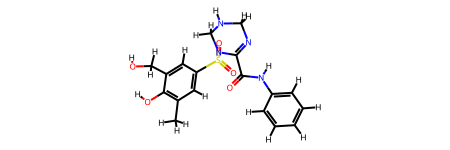

In [9]:
# unfortunately, py3Dmol fails to display any molecule that can't be sanitized by rdkit,
# so this cell may occasionally throw an error
sampled_mols = model.sample_random_sizes(n_molecules=1)
sampled_mols[0].rdkit_mol

In [ ]:
def mols_to_sdf(mols, filename):
    sdf_writer = Chem.SDWriter(filename)
    sdf_writer.SetKekulize(False)
    for mol in mols:
        try:
            # Chem.Sanitize
            sdf_writer.write(mol)
        except Exception as e:
            print(e)
            continue
    sdf_writer.close()

sampled_mol = model.sample_random_sizes(n_molecules=1, xt_traj=True, ep_traj=True)[0]

xt_traj_file = 'xt_traj.sdf'
ep_traj_file = 'ep_traj.sdf'
mols_to_sdf(sampled_mol.traj_mols, xt_traj_file)
mols_to_sdf(sampled_mol.ep_traj_mols, ep_traj_file)


# visualize trajectory
view = py3Dmol.view(width=800,height=400, linked=True, viewergrid=(1,2))

for i, filename in enumerate([xt_traj_file, ep_traj_file]):
    with open(filename) as f:
        sdf = f.read()
    view.addModelsAsFrames(sdf, format='sdf', viewer=(0,i))
view.addLabel("current state (gₜ)",{'position':{'x':0,'y':0,'z':0},'useScreen': True, 'fontSize': 24}, viewer=(0,0))
view.addLabel("Predicted final state (ĝ_1 given gₜ)",{'position':{'x':0,'y':0,'z':0},'useScreen': True, 'fontSize': 24}, viewer=(0,1))
view.setStyle({'stick':{}, 'sphere':{'scale': 0.2}},)
view.animate({'loop': 'forward', 'interval': 125},)
view.zoomTo()
view.zoom(0.75)
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

# Compute Metrics on Samples
the following cell samples 100 molecules and computes all of the metrics reported in the paper for the sample.

In [4]:
from flowmol.analysis.metrics import SampleAnalyzer

analyzer = SampleAnalyzer()
sampled_mols = model.sample_random_sizes(n_molecules=100)
analyzer.analyze(sampled_mols, energy_div=True, functional_validity=True)

Error messages: AtomValence 1, Kekulize 8, other 0,  -- No error 91


[00:11:29] Explicit valence for atom # 10 C, 5, is greater than permitted
[00:11:29] Can't kekulize mol.  Unkekulized atoms: 2 11 13 43 55
[00:11:29] Can't kekulize mol.  Unkekulized atoms: 9 10 15 17 30 36 54
[00:11:29] Can't kekulize mol.  Unkekulized atoms: 23
[00:11:29] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 8 11 15 17 19 20 27
[00:11:29] Can't kekulize mol.  Unkekulized atoms: 5 8 11 13 15 30 40 44 45
[00:11:29] Can't kekulize mol.  Unkekulized atoms: 6 9 11 14 21 23 28
[00:11:29] Can't kekulize mol.  Unkekulized atoms: 11 17 24 28 32 35 36
[00:11:29] Can't kekulize mol.  Unkekulized atoms: 14 18 24 29 30 32 34
[00:11:29] Can't kekulize mol.  Unkekulized atoms: 3 11 14
[00:11:29] Explicit valence for atom # 10 C, 5, is greater than permitted
[00:11:29] Can't kekulize mol.  Unkekulized atoms: 2 11 13 43 55
[00:11:29] Can't kekulize mol.  Unkekulized atoms: 9 10 15 17 30 36 54
[00:11:29] Can't kekulize mol.  Unkekulized atoms: 40
[00:11:29] Can't kekulize mol.  Unkekulized 

[00:11:30] Molecule does not have explicit Hs. Consider calling AddHs()
[00:11:30] Explicit valence for atom # 10 C, 5, is greater than permitted
[00:11:30] Can't kekulize mol.  Unkekulized atoms: 20 26 29
[00:11:30] Molecule does not have explicit Hs. Consider calling AddHs()
[00:11:30] Molecule does not have explicit Hs. Consider calling AddHs()
[00:11:30] Molecule does not have explicit Hs. Consider calling AddHs()
[00:11:30] Molecule does not have explicit Hs. Consider calling AddHs()
[00:11:30] Molecule does not have explicit Hs. Consider calling AddHs()
[00:11:30] Molecule does not have explicit Hs. Consider calling AddHs()
[00:11:30] Molecule does not have explicit Hs. Consider calling AddHs()


{'frac_atoms_stable': 0.9991349480968859,
 'frac_mols_stable_valence': 0.97,
 'frac_valid_mols': 0.91,
 'avg_frag_frac': 0.9408314896715995,
 'avg_num_components': 1.2,
 'flag_rate': 1.4,
 'ood_rate': 0.2222222222222222,
 'energy_js_div': 0.43672158927959037}